
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi


<font size=5 color=cyan> Names and student numbers:<br>
امیرمهدی وزیری - 402106756<br>
سینا اصولی‌نژاد - 402170884<br>
محمدمهدی عابدینی - 402106191
 </font>



In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [1]:
!pip install -q pybullet Box2D
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 71.3 MB/s eta 0:00:00
/bin/bash: line 1: nvidia-smi: command not found


Import necessary packages.

In [2]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
from gym.wrappers import RecordVideo
import gym
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [3]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [4]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False
        self.state_memory = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.next_state_memory = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.action_memory = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.reward_memory = np.zeros(buffer_size, dtype=np.float32)
        self.done_memory = np.zeros(buffer_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        index = self.ptr
        self.state_memory[index] = state
        self.next_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.done_memory[index] = done
        self.ptr = (self.ptr + 1) % self.buffer_size
        if self.ptr == 0:
            self.is_full = True

    def load_batch(self, batch_size):
        max_mem = self.buffer_size if self.is_full else self.ptr
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = T.tensor(self.state_memory[batch], dtype=T.float32)
        next_states = T.tensor(self.next_state_memory[batch], dtype=T.float32)
        actions = T.tensor(self.action_memory[batch], dtype=T.float32)
        rewards = T.tensor(self.reward_memory[batch], dtype=T.float32)
        done = T.tensor(self.done_memory[batch], dtype=T.float32)
        return states, actions, rewards, next_states, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [5]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # TODO 1: Save input arguments as attributes
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.beta = beta
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.ckpt_path = os.path.join(self.ckpt_dir, self.name+'_sac')

        # TODO 2: Define the first fully connected layer
        # Input: concatenated [state, action]
        self.fc1 = nn.Linear(self.state_dims + self.action_dims, fc1_dims)

        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)  # scalar output

        # TODO 4: Define the optimizer. Assign to the correct device
        self.optimizer = optim.Adam(self.parameters(), lr = self.beta)
        self.to(self.device)

    def forward(self, state, action):
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q


    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.alpha = alpha
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name+'_sac')


        # TODO 2: Define fully connected layers to transform input state
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)

        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mu = nn.Linear(fc2_dims, action_dims)
        self.log_sigma = nn.Linear(fc2_dims, action_dims)

        # TODO 4: Define optimizer and move model to the appropriate device
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha)
        self.to(self.device)

    def forward(self, state):
        state = state.to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_sigma = T.clamp(self.log_sigma(x), -20, 2)
        sigma = T.clamp(T.exp(log_sigma), 1e-6, 1.0)
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters

        # TODO 8: Create a normal distribution and sample from it
        mu, sigma = self.forward(state)
        dist = Normal(mu, sigma)
        u = dist.rsample() if reparameterize else dist.sample()
        a = T.tanh(u)
        action = a * self.max_action
        log_probs = dist.log_prob(u) - T.log(1 - a.pow(2) + 1e-6)
        log_probs = log_probs.sum(dim=1, keepdim=True)
        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # TODO 1: Save arguments as instance variables
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name+'_sac_value')


        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1)

        # TODO 3: Set optimizer and device
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)


    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [6]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        # TODO 1: Save all hyperparameters and paths

        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.tau = tau
        self.batch_size = batch_size
        self.max_action = max_action
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.ckpt_dir = ckpt_dir



        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)

        # TODO 2: Initialize the replay buffer
        self.memory = ReplayBuffer(memory_size, state_dims, action_dims)

        # TODO 3: Initialize Actor and Critic networks
        self.actor = Actor(alpha, state_dims, action_dims, fc1_dim, fc2_dim, max_action, reparam_noise_lim, name+'_actor', ckpt_dir)
        self.critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, name+'_critic1', ckpt_dir)
        self.critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, name+'_critic2', ckpt_dir)


        # TODO 4: Initialize Value and Target Value networks
        self.value = Value(beta, state_dims, fc1_dim, fc2_dim, name+'_value', ckpt_dir)
        self.target_value = Value(beta, state_dims, fc1_dim, fc2_dim, name+'_target_value', ckpt_dir)


        # TODO 5: Sync the parameters of value and target_value networks initially
        self.target_value.load_state_dict(self.value.state_dict())


    def choose_action(self, state, deterministic=False, reparameterize=False):

        # TODO 6: Convert state to tensor, move to device, and add batch dimension
        state = T.tensor([state], dtype=T.float32).to(self.actor.device)

        # TODO 7: Choose action from actor
        if deterministic:
            mu, _ = self.actor.forward(state)
            a = T.tanh(mu) * self.max_action
            return a.detach().cpu().numpy()[0]
        action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)
        return action.detach().cpu().numpy()[0]

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def load_batch(self):
        return self.memory.load_batch(self.batch_size)

    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        for target_param, param in zip(self.target_value.parameters(), self.value.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        # --- Warm-up / enough samples check ---
        num_in_buffer = self.memory.buffer_size if self.memory.is_full else self.memory.ptr
        if num_in_buffer < self.batch_size or (self.warmup and num_in_buffer < self.warmup):
            return

        # --- Load batch once ---
        states, actions, rewards, next_states, done = self.load_batch()
        device = self.actor.device
        states      = states.to(device)
        actions     = actions.to(device)
        rewards     = rewards.unsqueeze(1).to(device)
        next_states = next_states.to(device)
        done        = done.unsqueeze(1).to(device)

        # ===== VALUE LOSS =====
        # Sample actions from current policy (no grad through sample for value loss)
        actions_pi, log_probs_pi = self.actor.sample_normal(states, reparameterize=False)
        q1_pi = self.critic_1(states, actions_pi)
        q2_pi = self.critic_2(states, actions_pi)
        min_q_pi = T.min(q1_pi, q2_pi)
        target_v = (min_q_pi - self.alpha * log_probs_pi).detach()

        v_pred = self.value(states)
        v_loss = F.mse_loss(v_pred, target_v)
        self.value.optimizer.zero_grad()
        v_loss.backward()
        self.value.optimizer.step()

        # ===== ACTOR LOSS =====
        actions_reparam, log_probs = self.actor.sample_normal(states, reparameterize=True)
        q1_val = self.critic_1(states, actions_reparam)
        q2_val = self.critic_2(states, actions_reparam)
        min_q  = T.min(q1_val, q2_val)
        actor_loss = (self.alpha * log_probs - min_q).mean()
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        # ===== CRITIC LOSSES =====
        with T.no_grad():
            v_next = self.target_value(next_states)
            q_tgt = rewards * self.reward_scale + self.gamma * (1 - done) * v_next

        q1_pred = self.critic_1(states, actions)
        q2_pred = self.critic_2(states, actions)
        c1_loss = F.mse_loss(q1_pred, q_tgt)
        c2_loss = F.mse_loss(q2_pred, q_tgt)

        self.critic_1.optimizer.zero_grad()
        c1_loss.backward()
        self.critic_1.optimizer.step()

        self.critic_2.optimizer.zero_grad()
        c2_loss.backward()
        self.critic_2.optimizer.step()

        # ===== TARGET VALUE POLYAK UPDATE =====
        self.update_parameters(self.tau)

        self.learn_iter += 1



## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [7]:
# Configuration parameters


env_name = 'HalfCheetahBulletEnv-v0'
dir = 'tmp'
n_games = 1200


gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
# Add other network dims if needed

memory_size = 35000
batch_size = 192
tau = 0.005
update_period = 2
reward_scale = 2.0
warmup = 1000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/1200 [00:00<?, ?it/s]

| Game:      0 | Score:   -1112.58 | Best score:   -1112.58 | Avg score   -1112.58 | Learning iter:          0 |
| Game:      1 | Score:   -1370.55 | Best score:   -1112.58 | Avg score   -1241.57 | Learning iter:        500 |
| Game:      2 | Score:   -1322.74 | Best score:   -1112.58 | Avg score   -1268.63 | Learning iter:       1000 |
| Game:      3 | Score:   -1279.65 | Best score:   -1112.58 | Avg score   -1271.38 | Learning iter:       1500 |
| Game:      4 | Score:   -1055.82 | Best score:   -1055.82 | Avg score   -1228.27 | Learning iter:       2000 |
| Game:      5 | Score:   -1355.41 | Best score:   -1055.82 | Avg score   -1249.46 | Learning iter:       2500 |
| Game:      6 | Score:   -1258.18 | Best score:   -1055.82 | Avg score   -1250.71 | Learning iter:       3000 |
| Game:      7 | Score:   -1246.08 | Best score:   -1055.82 | Avg score   -1250.13 | Learning iter:       3500 |
| Game:      8 | Score:   -1509.02 | Best score:   -1055.82 | Avg score   -1278.89 | Learning it

/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:67: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment HalfCheetahBulletEnv-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:149: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argum

| Game:   1198 | Score:    1630.38 | Best score:    2016.56 | Avg score    1722.25 | Learning iter:     599000 |


/usr/local/lib/python3.12/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


| Game:   1199 | Score:    1774.09 | Best score:    2016.56 | Avg score    1721.37 | Learning iter:     599500 |


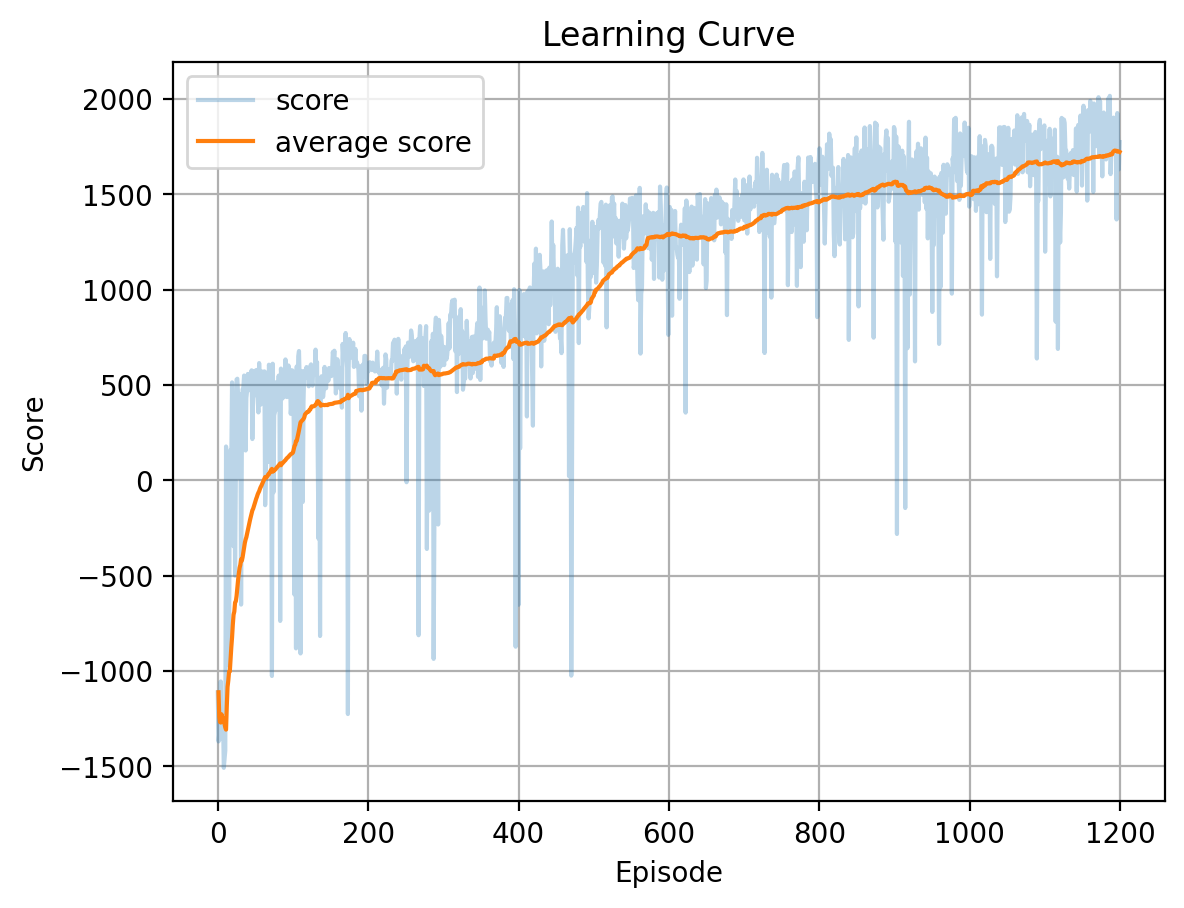

In [12]:
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)

agent = Agent(
    gamma, alpha, beta,
    env.observation_space.shape[0],
    env.action_space.shape[0],
    env.action_space.high[0],
    fc1_dim, fc2_dim,
    memory_size, batch_size,
    tau, update_period,
    reward_scale, warmup,
    reparam_noise_lim,
    name='SAC',
    ckpt_dir=dir
)

# TODO: Initialize performance tracking variables
scores = []
max_score = -np.inf
total_steps = 0

for game in trange(n_games):
    # TODO: Reset environment and initialize variables at the start of each episode
    state = env.reset()
    done = False
    score = 0.0

    # TODO: Interact with the environment until the episode is done
    while not done:
        # Use random actions during warmup to prevent NaNs
        if total_steps < agent.warmup:
            action = env.action_space.sample()
        else:
            # TODO: Select action and interact
            action = agent.choose_action(state, deterministic=False, reparameterize=False)

        next_state, reward, done, _ = env.step(action)

        # Store in replay buffer
        agent.store_transition(state, action, reward, next_state, done)

        # Update agent
        if (total_steps % update_period == 0):
            agent.learn()

        state = next_state
        score += reward
        total_steps += 1

    # TODO: Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    max_score = max(max_score, score)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {max_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

env.close()
plot_learning_curve(scores, agent.full_path)

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [13]:
Video(f"/content/tmp/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)